In [119]:
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor

In [104]:
conn = sqlite3.connect('Shared DC2 Group 19\\database_final.db')

query_burg = """SELECT * FROM table_name
WHERE "Crime Type" = "Burglary"
"""
query_sun = """SELECT * FROM sunlight"""
query_house = """SELECT * FROM housing_by_lsoa"""

df_burglary_all = pd.read_sql(query_burg, conn)
df_sunlight = pd.read_sql(query_sun, conn)
df_housing = pd.read_sql(query_house, conn)

conn.close()

In [105]:
"""file_path ='Shared DC2 Group 19\\Cleaned Data\\conc_clean.csv'
df_burglary = pd.read_csv(file_path)"""

"file_path ='Shared DC2 Group 19\\Cleaned Data\\conc_clean.csv'\ndf_burglary = pd.read_csv(file_path)"

In [106]:
df_burglary = df_burglary_all.drop(columns=['Reported by', 'Falls within']).dropna()
df_burglary

df_bar=df_burglary[df_burglary['LSOA name'].str.contains('Barnet')]
df_bar['Month'] = pd.to_datetime(df_bar['Month'])
df_bar['Year']= df_bar['Month'].dt.year
df_bar_2019 =df_bar[ df_bar['Year'] == 2019]
df_bar.head()

C:\Users\shash\AppData\Local\Temp\ipykernel_27532\2394267841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar['Month'] = pd.to_datetime(df_bar['Month'])
C:\Users\shash\AppData\Local\Temp\ipykernel_27532\2394267841.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar['Year']= df_bar['Month'].dt.year


,Month,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Year
149,2010-12-01,-0.201877,51.655538,On or near High Street,E01000248,Barnet 001A,Burglary,2010
150,2010-12-01,-0.207853,51.654317,On or near The Avenue,E01000248,Barnet 001A,Burglary,2010
151,2010-12-01,-0.202510,51.656348,On or near Bruce Road,E01000248,Barnet 001A,Burglary,2010
152,2010-12-01,-0.206779,51.654768,On or near The Drive,E01000248,Barnet 001A,Burglary,2010
153,2010-12-01,-0.209537,51.655223,On or near Marriott Road,E01000249,Barnet 001B,Burglary,2010


In [107]:
df_sunlight['Month'] = pd.to_datetime(df_sunlight['Year-Month'])
df_sunlight=df_sunlight.drop(columns=["Year-Month", "index"], axis=1)
#df_sunlight
df_sunlight.head()

,Sunlight,Month
0,2.448102,2001-01-01
1,3.125319,2001-02-01
2,2.953300,2001-03-01
3,4.744445,2001-04-01
4,7.725524,2001-05-01


In [108]:
df_housing = df_housing.drop(columns=["index"], axis=1)
df_housing.head()

,LSOA code,LSOA name,Owned or shared ownership,Private Rented or lives rent free,Social Rented,Proportion social,Proportion rented,Detached whole house or bungalow,Semi-detached whole house or bungalow,Terraced (including end-terrace) whole house or bungalow,"Flat, maisonette or apartment",A caravan or other mobile or temporary structure,Proportion of indep,1 bedroom,2 bedrooms,3 bedrooms,4 or more bedrooms,Missing,Proportion small house
0,E01000001,City of London 001A,485,330,20,0.023952,0.419162,0,0,15,1060,0,0.013953,375,280,140,45,0,0.779762
1,E01000002,City of London 001B,435,365,25,0.030303,0.472727,0,0,30,1145,0,0.025532,405,265,100,50,0,0.817073
2,E01000003,City of London 001C,380,335,300,0.295567,0.625616,0,0,0,1280,0,0.000000,650,300,60,0,0,0.940594
3,E01000005,City of London 001E,40,105,335,0.697917,0.916667,0,0,0,615,0,0.000000,240,135,95,0,0,0.797872
4,E01000006,Barking and Dagenham 016A,275,255,25,0.045045,0.504505,35,90,300,155,0,0.732759,95,70,255,130,0,0.300000


In [109]:
burglaries_per_lsoa_month = df_bar[df_bar['Crime type'] == 'Burglary'].groupby(['LSOA code', 'Month']).size()

burglaries_per_lsoa_month = burglaries_per_lsoa_month.reset_index(name='Total Burglaries')
#burglaries_per_lsoa_month["Total Burglaries"].unique()
burglaries_per_lsoa_month.head()

,LSOA code,Month,Total Burglaries
0,E01000115,2011-01-01,2
1,E01000115,2011-04-01,1
2,E01000115,2011-08-01,1
3,E01000115,2011-12-01,4
4,E01000115,2012-01-01,2


In [110]:
temp_merged = burglaries_per_lsoa_month.merge(df_housing, how='left', on=['LSOA code']).dropna()

df_merged = temp_merged.merge(df_sunlight, how='left', on=['Month'])
df_merged 
temp_merged_clean = temp_merged.drop(columns=['Missing', 'LSOA name'])
temp_merged_clean

# Create dummy variables for the 'LSOA code' column
dummy_df = pd.get_dummies(temp_merged_clean['LSOA code'], prefix='LSOA')

# Concatenate the dummy variables with the original DataFrame
df_temp_merged_clean_dummies = pd.concat([temp_merged_clean, dummy_df], axis=1)


In [111]:
df_temp_merged_clean_train = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year >= 2014) & (df_temp_merged_clean_dummies['Month'].dt.year <= 2018)]
df_temp_merged_clean_train
df_temp_merged_clean_test = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year == 2019)]
df_temp_merged_clean_test



,LSOA code,Month,Total Burglaries,Owned or shared ownership,Private Rented or lives rent free,Social Rented,Proportion social,Proportion rented,Detached whole house or bungalow,Semi-detached whole house or bungalow,Terraced (including end-terrace) whole house or bungalow,"Flat, maisonette or apartment",A caravan or other mobile or temporary structure,Proportion of indep,1 bedroom,2 bedrooms,3 bedrooms,4 or more bedrooms,Proportion small house,LSOA_E01000115,LSOA_E01000116,LSOA_E01000117,LSOA_E01000118,LSOA_E01000119,LSOA_E01000120,LSOA_E01000121,LSOA_E01000122,LSOA_E01000123,LSOA_E01000124,LSOA_E01000126,LSOA_E01000127,LSOA_E01000128,LSOA_E01000129,LSOA_E01000130,LSOA_E01000131,LSOA_E01000132,LSOA_E01000133,LSOA_E01000134,LSOA_E01000135,LSOA_E01000136,...,LSOA_E01000285,LSOA_E01000286,LSOA_E01000287,LSOA_E01000288,LSOA_E01000289,LSOA_E01000290,LSOA_E01000291,LSOA_E01000292,LSOA_E01000293,LSOA_E01000294,LSOA_E01000295,LSOA_E01000296,LSOA_E01000297,LSOA_E01000298,LSOA_E01000299,LSOA_E01000300,LSOA_E01000301,LSOA_E01000302,LSOA_E01000303,LSOA_E01000304,LSOA_E01000305,LSOA_E01000306,LSOA_E01000307,LSOA_E01000308,LSOA_E01000309,LSOA_E01000310,LSOA_E01000311,LSOA_E01000312,LSOA_E01000313,LSOA_E01000314,LSOA_E01000315,LSOA_E01000316,LSOA_E01000317,LSOA_E01000318,LSOA_E01000319,LSOA_E01000320,LSOA_E01000321,LSOA_E01000322,LSOA_E01000323,LSOA_E01000324
47,E01000115,2019-01-01,2,435.0,45.0,0.0,0.000000,0.093750,135.0,335.0,0.0,15.0,0.0,0.969072,0.0,10.0,205.0,255.0,0.021277,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48,E01000115,2019-02-01,1,435.0,45.0,0.0,0.000000,0.093750,135.0,335.0,0.0,15.0,0.0,0.969072,0.0,10.0,205.0,255.0,0.021277,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49,E01000115,2019-03-01,3,435.0,45.0,0.0,0.000000,0.093750,135.0,335.0,0.0,15.0,0.0,0.969072,0.0,10.0,205.0,255.0,0.021277,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50,E01000115,2019-04-01,1,435.0,45.0,0.0,0.000000,0.093750,135.0,335.0,0.0,15.0,0.0,0.969072,0.0,10.0,205.0,255.0,0.021277,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51,E01000115,2019-05-01,1,435.0,45.0,0.0,0.000000,0.093750,135.0,335.0,0.0,15.0,0.0,0.969072,0.0,10.0,205.0,255.0,0.021277,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20748,E01000324,2019-06-01,2,440.0,155.0,55.0,0.084615,0.323077,35.0,255.0,145.0,235.0,0.0,0.649254,70.0,145.0,215.0,215.0,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20749,E01000324,2019-07-01,1,440.0,155.0,55.0,0.084615,0.323077,35.0,255.0,145.0,235.0,0.0,0.649254,70.0,145.0,215.0,215.0,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20750,E01000324,2019-08-01,1,440.0,155.0,55.0,0.084615,0.323077,35.0,255.0,145.0,235.0,0.0,0.649254,70.0,145.0,215.0,215.0,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20751,E01000324,2019-11-01,1,440.0,155.0,55.0,0.084615,0.323077,35.0,255.0,145.0,235.0,0.0,0.649254,70.0,145.0,215.0,215.0,0.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [115]:

X_train = df_temp_merged_clean_train.drop(columns=["Total Burglaries", "Month", "LSOA code"], axis = 1)
y_train = df_temp_merged_clean_train["Total Burglaries"]
X_test = df_temp_merged_clean_test.drop(columns=["Total Burglaries", "Month", "LSOA code"], axis = 1)
y_test = df_temp_merged_clean_test["Total Burglaries"]


In [116]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

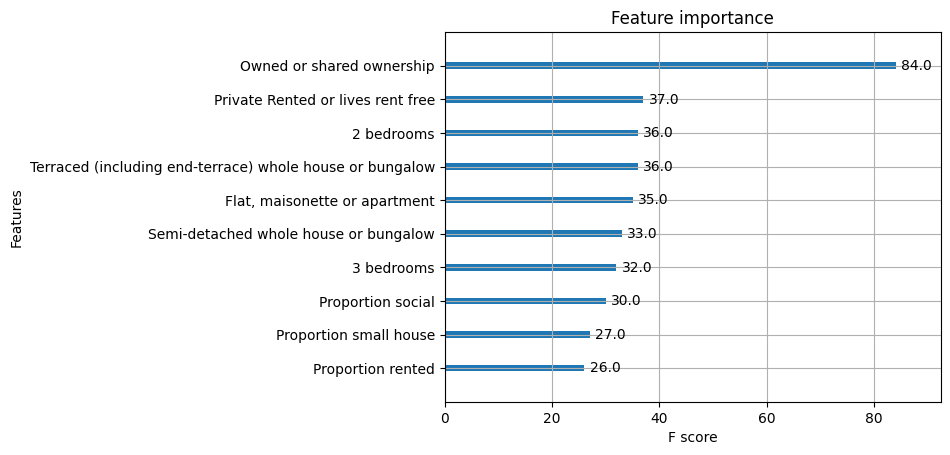

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

xgb.plot_importance(model, ax=plt.gca(), max_num_features=10)

In [123]:
pred_train = model.predict(X_train)
from sklearn.metrics import mean_squared_error, r2_score
predictions = model.predict(X_test)

0.08712690304365489


In [134]:
#train
print("MSE Train " + str(mean_squared_error(y_train, pred_train)))

MSE 1.6922285435904376


In [136]:
#test
print("MSE Test " + str(mean_squared_error(y_test, predictions)) + "  R^2 " + str(r2_score(y_test, predictions)))

MSE Test 1.606857709817004  R^2 0.05372234422776556


In [129]:
model.score(X_test, y_test) 

0.05372234422776556